In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
import scanpy as sc
import cellrank as cr
import wandb
import magic
import anndata

In [2]:
adata = cr.datasets.pancreas()

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, retain_genes=['Hhex'])
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

class RNAvelo(nn.Module):
    def __init__(self, feature_size):
        super(RNAvelo, self).__init__()
        self.feature_size = feature_size
        self.log_alpha = nn.Parameter(torch.rand(feature_size))
        self.log_beta = nn.Parameter(torch.rand(feature_size))
        self.log_gamma = nn.Parameter(torch.rand(feature_size))
        
    def forward(self, t, x):
        # x shape as (n, 2m)
        if len(x.shape) == 1:
            du = x[:self.feature_size]
            ds = x[self.feature_size:]
            du_dt = torch.exp(self.log_alpha) - torch.exp(self.log_beta) * du
            ds_dt = torch.exp(self.log_beta) * du - torch.exp(self.log_gamma) * ds
            return torch.cat([du_dt, ds_dt])
            
        else:
            du = x[:,:self.feature_size]
            ds = x[:,self.feature_size:]
        
            du_dt = torch.exp(self.log_alpha) - torch.exp(self.log_beta) * du
            ds_dt = torch.exp(self.log_beta) * du - torch.exp(self.log_gamma) * ds
        
            return torch.cat([du_dt, ds_dt],dim=1)
    
    def params(self,):
        return torch.exp(self.log_alpha).detach().cpu().numpy(), torch.exp(self.log_beta).detach().cpu().numpy(), torch.exp(self.log_gamma).detach().cpu().numpy()
    
    def predict(self, t, x):

        v = self.forward(t,x)
        v = v.cpu().detach().numpy()
        return v[:,:self.feature_size], v[:,self.feature_size:]

def fit_neural_ode(adata, num_epochs=300, device='cuda'):
    # Sort adata based on pseudo-time
    pseudo_time = adata.obs['palantir_pseudotime'].values
    sorted_indices = np.argsort(pseudo_time)
    adata = adata[sorted_indices,]
    # Check if CUDA is available and set the device accordingly
    if device == 'cuda':
        device = device if torch.cuda.is_available() else 'cpu'
    else:
        device = device
    
    print(f"Training on device: {device}")
    # Extract the expression matrix and pseudo-time
    
    u = torch.tensor(adata.layers['Mu'], dtype=torch.float32).to(device)
    s = torch.tensor(adata.layers['Ms'], dtype=torch.float32).to(device)
    expression_matrix = torch.cat([u, s],dim=1)
    pseudo_time = torch.tensor(adata.obs['palantir_pseudotime'], dtype=torch.float32).to(device)

    # Feature size is the number of genes (columns) in the expression matrix
    n_samples, feature_size = u.shape[0], u.shape[1]

    # Initialize the ODE function with a neural network
    velo_model = RNAvelo(feature_size=feature_size).to(device)

    # Define an optimizer
    optimizer = torch.optim.Adam(velo_model.parameters(), lr=5e-2)

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Predict the state at the next pseudo-time point
        predicted = odeint(velo_model, expression_matrix[0], pseudo_time)
        # Calculate loss (e.g., mean squared error between predicted and actual expression)
        loss = F.l1_loss(predicted, expression_matrix)
        # Backpropagation
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: loss = {loss.item()}')
    
    # After training, use the ODE function to estimate velocity
    u_v, s_v = velo_model.predict(pseudo_time, expression_matrix)
    alpha, beta, gamma = velo_model.params()
    alpha = np.repeat(alpha.reshape(1, -1), n_samples, axis=0)
    beta = np.repeat(beta.reshape(1, -1), n_samples, axis=0)
    gamma = np.repeat(gamma.reshape(1, -1), n_samples, axis=0)
    
    adata.layers['alpha'] = alpha
    adata.layers['beta'] = beta
    adata.layers['gamma'] = gamma
    adata.layers['velocity'] = s_v
    adata.layers['unspliced_velocity'] = u_v
    
    return adata

In [15]:
adata_list = []
for i in adata.obs['clusters'].value_counts().index:
    adata_i = adata[adata.obs['clusters'] == i].copy()
    adata_i = fit_neural_ode(adata_i, num_epochs=100)
    adata_list.append(adata_i)

adata = anndata.concat(adata_list, axis=0)


Training on device: cuda
Epoch 0: loss = 0.3259623050689697
Epoch 10: loss = 0.27451884746551514
Epoch 20: loss = 0.2436409592628479
Epoch 30: loss = 0.2271960973739624
Epoch 40: loss = 0.21833978593349457
Epoch 50: loss = 0.2125510275363922
Epoch 60: loss = 0.20756828784942627
Epoch 70: loss = 0.20004409551620483
Epoch 80: loss = 0.18784475326538086
Epoch 90: loss = 0.17977096140384674
Training on device: cuda
Epoch 0: loss = 0.3901998996734619
Epoch 10: loss = 0.28842970728874207
Epoch 20: loss = 0.23243139684200287
Epoch 30: loss = 0.20213234424591064
Epoch 40: loss = 0.18512505292892456
Epoch 50: loss = 0.17281384766101837
Epoch 60: loss = 0.1641029268503189
Epoch 70: loss = 0.15320612490177155
Epoch 80: loss = 0.14466895163059235
Epoch 90: loss = 0.14114844799041748
Training on device: cuda
Epoch 0: loss = 0.44696304202079773
Epoch 10: loss = 0.29909664392471313
Epoch 20: loss = 0.2181304693222046
Epoch 30: loss = 0.1774309277534485
Epoch 40: loss = 0.1566534787416458
Epoch 50: lo

In [16]:
np.linalg.norm(adata.layers['velocity'], ord=2, axis=1).max()

3011.935

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 16/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


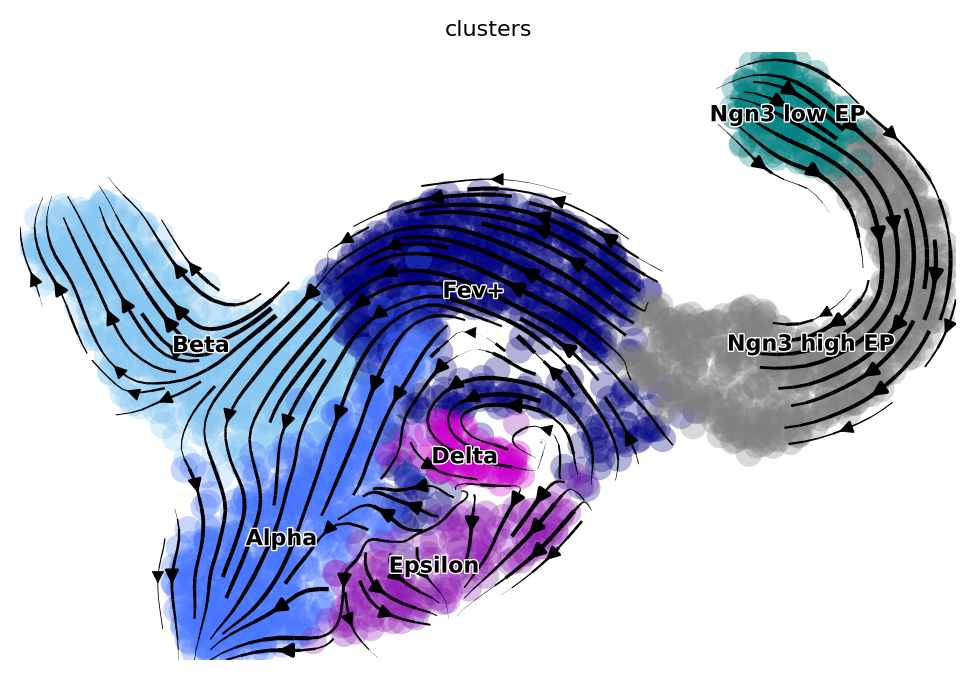

In [17]:
scv.tl.velocity_graph(adata, n_jobs=-1)
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [18]:
i = 910

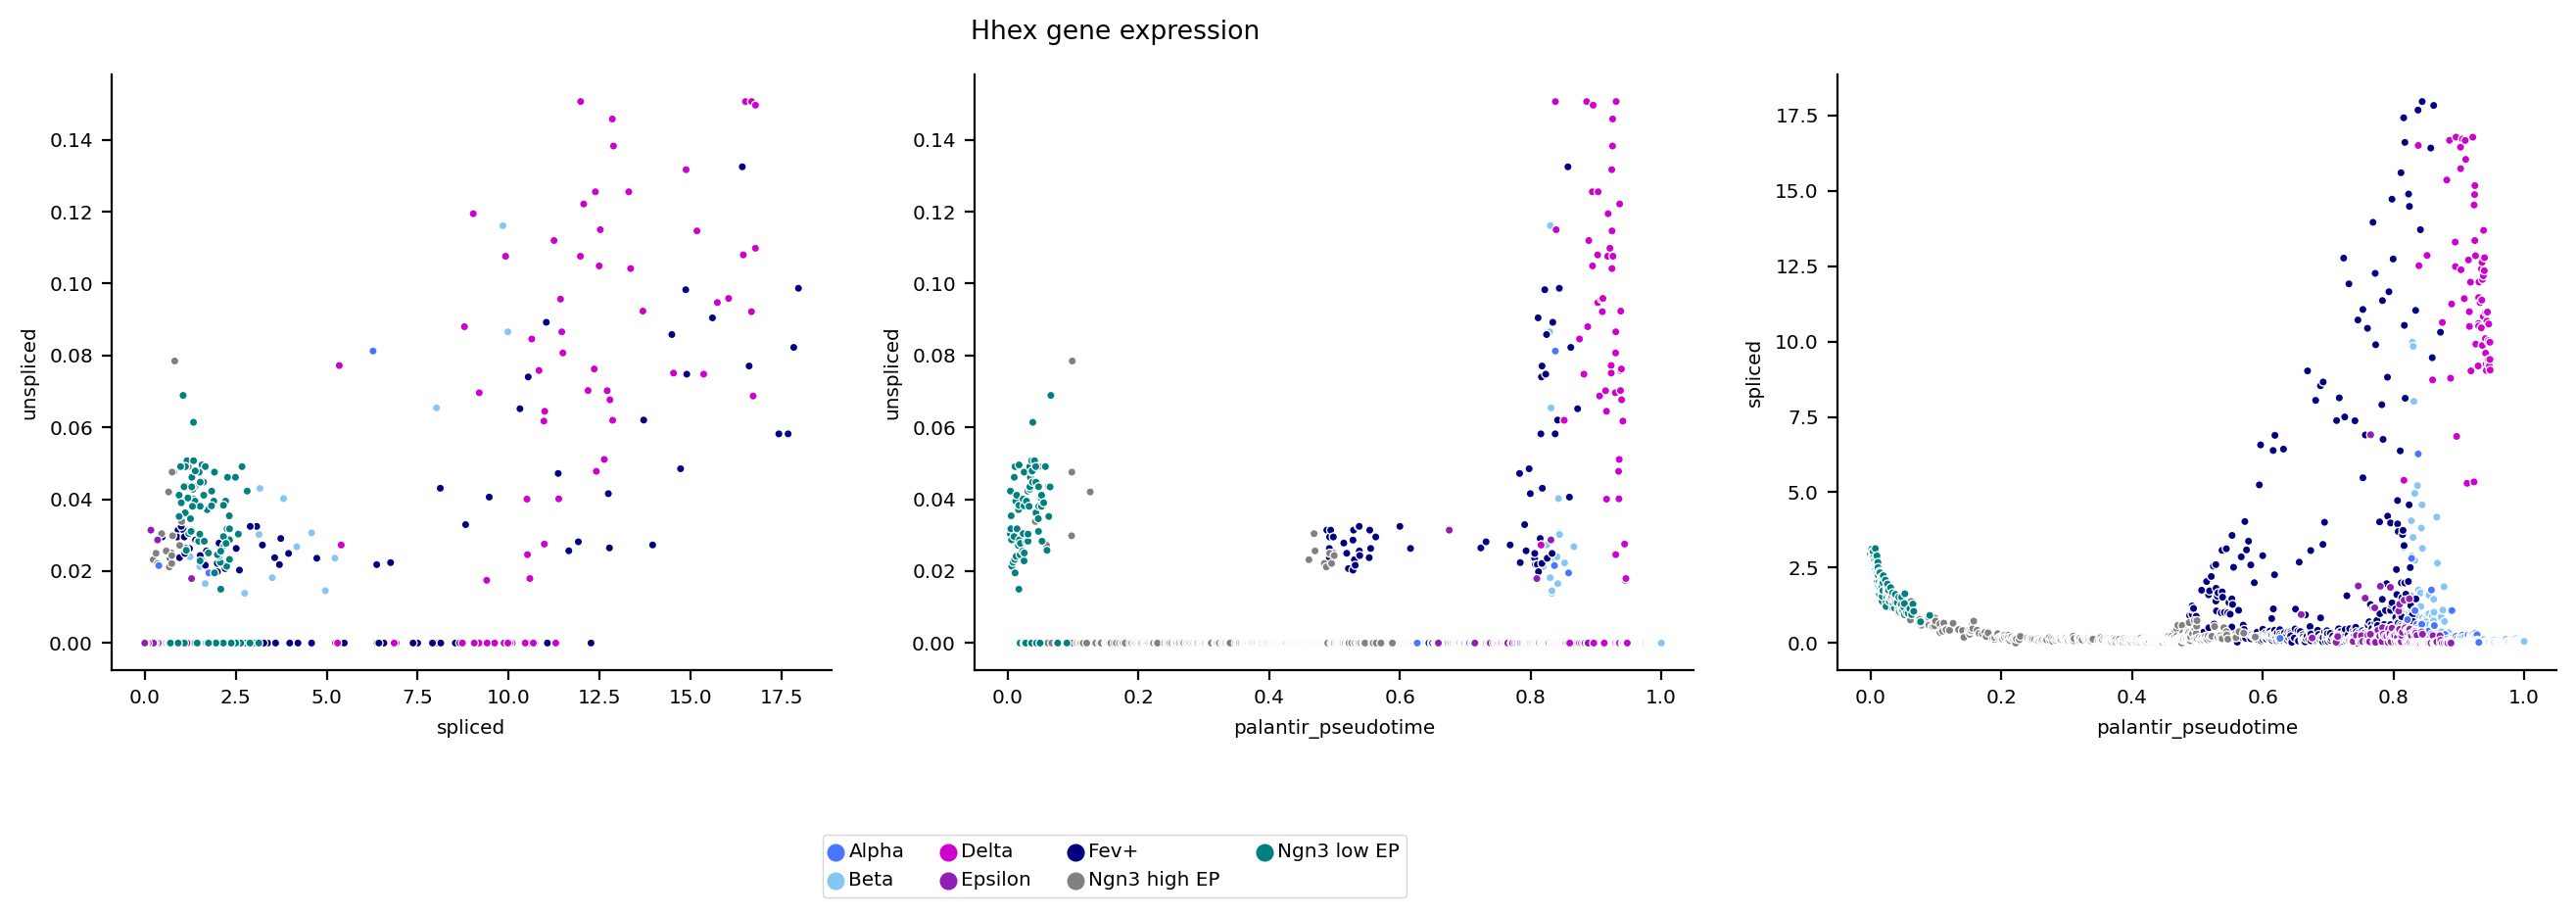

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[0])
axes[0].set_ylabel('unspliced')
axes[0].set_xlabel('spliced')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[1])
axes[1].set_ylabel('unspliced')
axes[1].set_xlabel('palantir_pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[2])
axes[2].set_ylabel('spliced')
axes[2].set_xlabel('palantir_pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle(adata.var.iloc[i].name+' gene expression')
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()


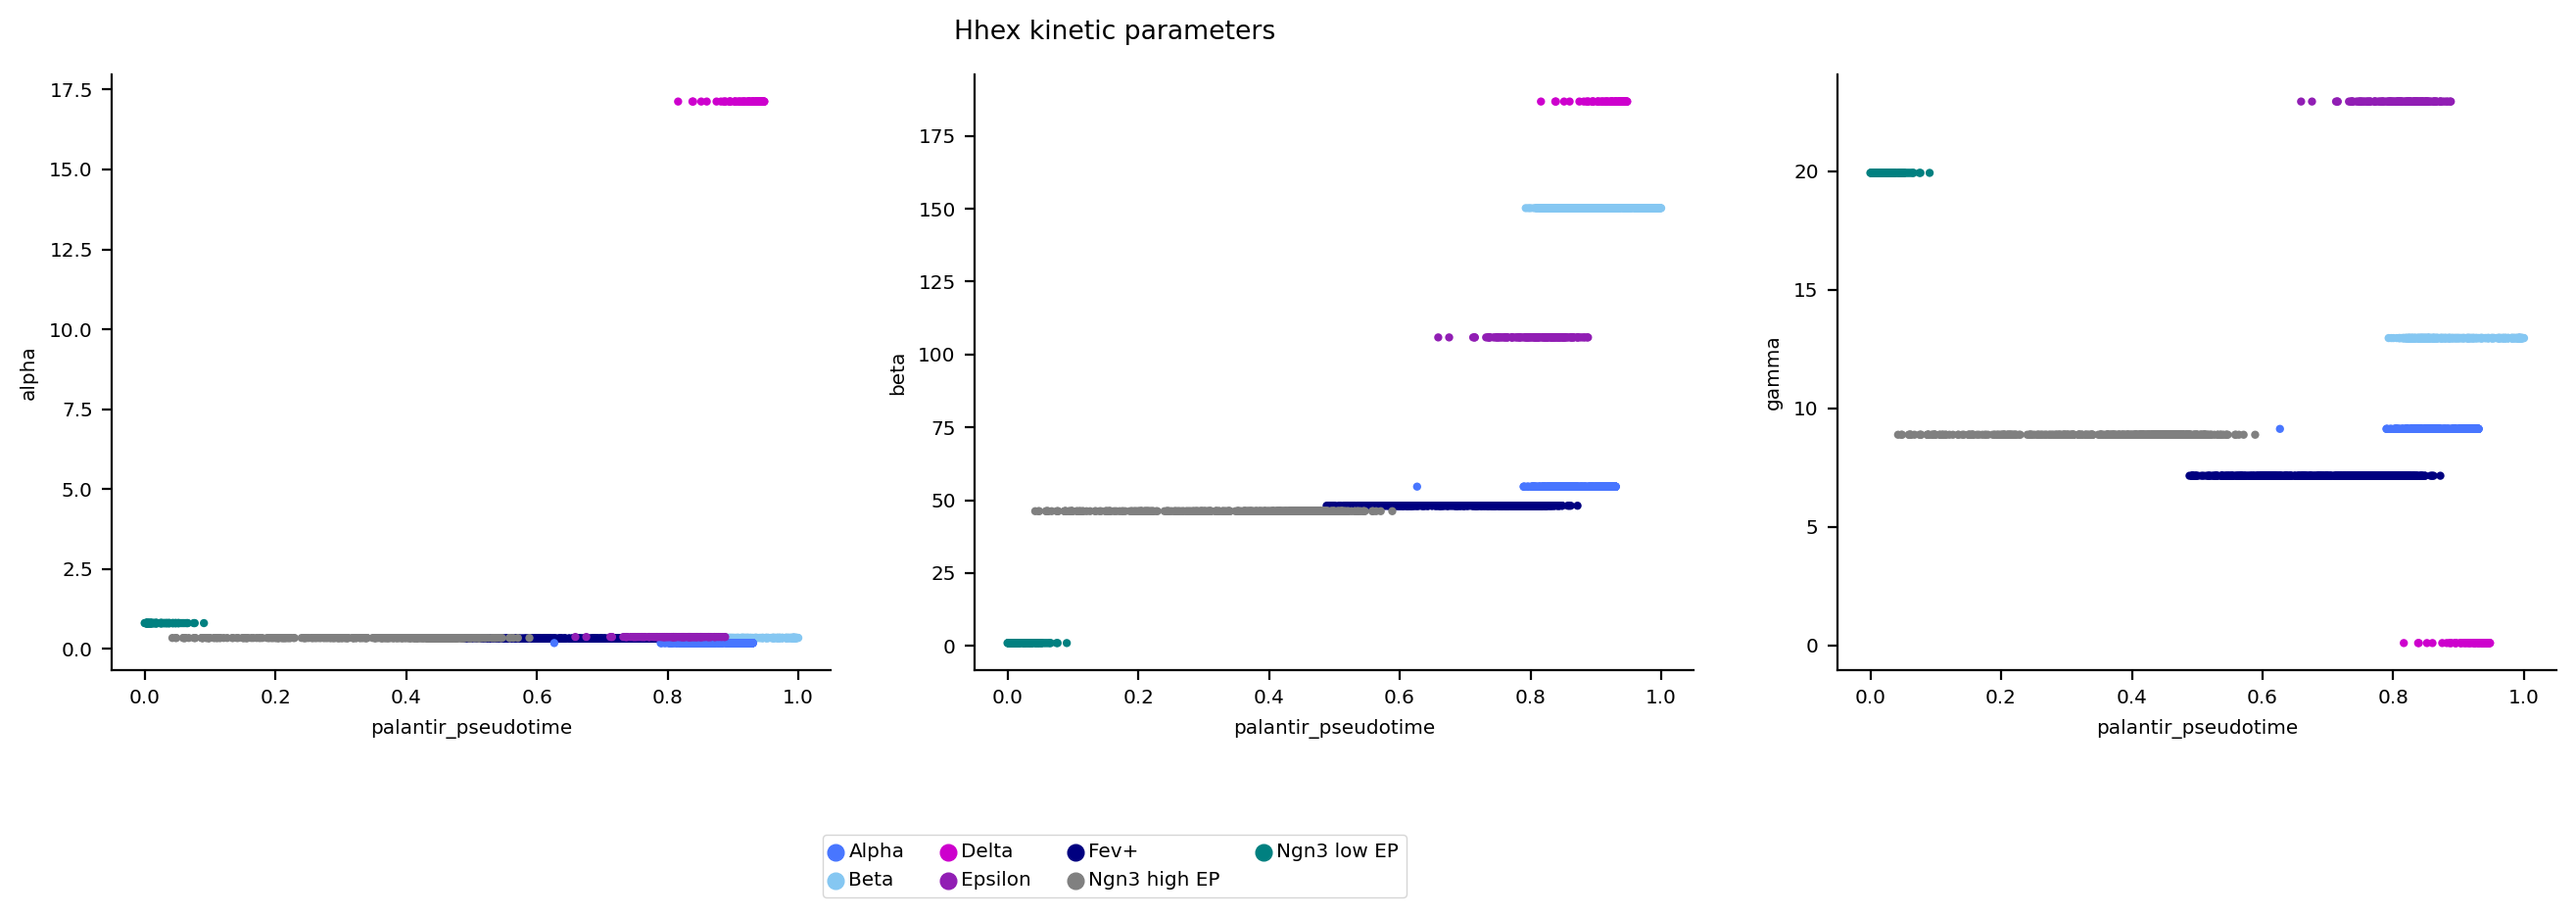

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['alpha'][:, i],
                hue=adata.obs['clusters'], marker='.',edgecolor='none', ax=axes[0])
axes[0].set_ylabel('alpha')
axes[0].set_xlabel('palantir_pseudotime')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['beta'][:, i],
                hue=adata.obs['clusters'], marker='.',edgecolor='none', ax=axes[1])
axes[1].set_ylabel('beta')
axes[1].set_xlabel('palantir_pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['gamma'][:, i],
                hue=adata.obs['clusters'], marker='.',edgecolor='none', ax=axes[2])
axes[2].set_ylabel('gamma')
axes[2].set_xlabel('palantir_pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)

# Get handles and labels for the legend
handles, labels = axes[0].get_legend_handles_labels()

fig.suptitle(adata.var.iloc[i].name+' kinetic parameters')

# Create a single legend
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()